In [1]:
import sys
import os
sys.path.insert(0, os.getcwd())
from data.utils import FeatureEngineer, data_split, load_dataset
import pickle
import copy
from sklearn import preprocessing
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.pyplot import MultipleLocator
%matplotlib inline
import random
from collections import defaultdict


/mnt/cache/chenyun/anaconda3/envs/gnn/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
df = load_dataset(file_name = './data/data.csv')
tech_indicator_list = ['macd', 'rsi_30', 'cci_30', 'dx_30']
fe = FeatureEngineer(
    use_technical_indicator=True,
    tech_indicator_list=tech_indicator_list,
    use_turbulence=False,
    user_defined_feature=False
)
df = fe.clean_data(df)
print(df)

            date   tic    open    high     low   close   volume    target
0     2017-01-04  1301  2734.0  2755.0  2730.0  2742.0    31400  0.000730
0     2017-01-04  1332   568.0   576.0   563.0   571.0  2798500  0.012324
0     2017-01-04  1333  3150.0  3210.0  3140.0  3210.0   270800  0.006154
0     2017-01-04  1376  1510.0  1550.0  1510.0  1550.0    11300  0.011053
0     2017-01-04  1377  3270.0  3350.0  3270.0  3330.0   150800  0.003026
...          ...   ...     ...     ...     ...     ...      ...       ...
1200  2021-12-03  9990   514.0   528.0   513.0   528.0    44200  0.034816
1200  2021-12-03  9991   782.0   794.0   782.0   794.0    35900  0.025478
1200  2021-12-03  9993  1690.0  1690.0  1645.0  1645.0     7200 -0.004302
1200  2021-12-03  9994  2388.0  2396.0  2380.0  2389.0     6500  0.009098
1200  2021-12-03  9997   690.0   711.0   686.0   696.0   381100  0.018414

[2122167 rows x 8 columns]


In [13]:
tic_var = {}
for tic in df['tic'].unique():
    close_var = df[df.tic == tic]['close'].var()
    tic_var[tic] = close_var
sorted_var = sorted(tic_var.items(), key=lambda x:x[1], reverse=True)
top100_tic = [k[0] for k in sorted_var][:100]
df = df[df.tic.isin(top100_tic)]
df.reset_index(drop=True, inplace=True)
df = df.sort_values(['tic','date']).reset_index(drop=True)
df.index = df.tic.factorize()[0]
print(df)
with open("./data/data_top100.pkl", 'wb') as f:
    pickle.dump(df, f)

          date   tic    open    high     low   close    volume    target
0   2017-01-04  1435  4165.0  4180.0  4100.0  4165.0     95700 -0.023641
0   2017-01-05  1435  4165.0  4240.0  4160.0  4230.0     88000 -0.033898
0   2017-01-06  1435  4230.0  4265.0  4105.0  4130.0    120900 -0.020050
0   2017-01-10  1435  4065.0  4085.0  3980.0  3990.0    155800 -0.017903
0   2017-01-11  1435  3990.0  4020.0  3900.0  3910.0    116000  0.014323
..         ...   ...     ...     ...     ...     ...       ...       ...
99  2021-11-29  9984  6200.0  6376.0  6172.0  6208.0  18069400 -0.021559
99  2021-11-30  9984  6300.0  6336.0  6000.0  6030.0  20287700 -0.051017
99  2021-12-01  9984  6008.0  6050.0  5807.0  5900.0  22539600 -0.007144
99  2021-12-02  9984  5769.0  5808.0  5539.0  5599.0  28549500 -0.082029
99  2021-12-03  9984  5570.0  5637.0  5423.0  5559.0  25516400  0.079365

[120100 rows x 8 columns]


In [15]:
with open("./data/data_top100.pkl", 'rb') as f:
    df = pickle.load(f)
df = fe.preprocess_data(df)
print(df)
with open("./data/data_add_tech.pkl", 'wb') as f:
    pickle.dump(df, f)

Successfully added technical indicators
              date   tic     open     high      low    close    volume  \
0       2017-01-04  1435   4165.0   4180.0   4100.0   4165.0     95700   
1201    2017-01-04  1766   8330.0   8580.0   8330.0   8580.0     55900   
2402    2017-01-04  1878  17690.0  17845.0  17535.0  17810.0    335000   
3603    2017-01-04  1884    457.0    471.0    457.0    471.0    250000   
4804    2017-01-04  2217    506.0    514.0    506.0    512.0     62000   
...            ...   ...      ...      ...      ...      ...       ...   
115295  2021-12-03  9632   8040.0   8220.0   8040.0   8130.0      2500   
116496  2021-12-03  9663  10760.0  11250.0  10760.0  11140.0     22000   
117697  2021-12-03  9843  18040.0  18400.0  17975.0  18330.0    252700   
118898  2021-12-03  9983  66010.0  67000.0  65380.0  66650.0    860900   
120099  2021-12-03  9984   5570.0   5637.0   5423.0   5559.0  25516400   

          target         macd      rsi_30      cci_30       dx_30  
0  

In [17]:
with open("./data/data_add_tech.pkl", 'rb') as f:
    df = pickle.load(f)
df = df.sort_values(['tic','date']).reset_index(drop=True)
df.index = df.tic.factorize()[0]
scaler = preprocessing.StandardScaler()
for i in range(len(df.index.unique())):
    tmp_df = df.loc[i]
    tmp_df_shift = tmp_df.shift(1)
    tmp_df_shift.iloc[0] = tmp_df.iloc[0]
    tmp_df.iloc[:, 2:7] = tmp_df.iloc[:, 2:7].div(tmp_df_shift.iloc[:, 2:7], axis = 0)
    for j in tech_indicator_list:
        scale_param = scaler.fit(tmp_df[j].values.reshape(-1, 1))
        tmp_df[j] = scaler.fit_transform(tmp_df[j].values.reshape(-1, 1), scale_param)
    df.loc[i] = tmp_df
print(df)
with open("./data/data_scale.pkl", 'wb') as f:
    pickle.dump(df, f)

          date   tic      open      high       low     close    volume  \
0   2017-01-04  1435  1.000000  1.000000  1.000000  1.000000  1.000000   
0   2017-01-05  1435  1.000000  1.014354  1.014634  1.015606  0.919540   
0   2017-01-06  1435  1.015606  1.005896  0.986779  0.976359  1.373864   
0   2017-01-10  1435  0.960993  0.957796  0.969549  0.966102  1.288668   
0   2017-01-11  1435  0.981550  0.984088  0.979899  0.979950  0.744544   
..         ...   ...       ...       ...       ...       ...       ...   
99  2021-11-29  9984  0.935143  0.961109  0.976428  0.979798  0.831239   
99  2021-11-30  9984  1.016129  0.993726  0.972132  0.971327  1.122766   
99  2021-12-01  9984  0.953651  0.954861  0.967833  0.978441  1.110998   
99  2021-12-02  9984  0.960220  0.960000  0.953849  0.948983  1.266637   
99  2021-12-03  9984  0.965505  0.970558  0.979058  0.992856  0.893760   

      target      macd    rsi_30    cci_30     dx_30  
0  -0.023641  0.115095  5.001457  0.613386  4.030403  
0

In [2]:
def calc_spread_return_per_day(one_day_data, portfolio_size: int = 10, toprank_weight_ratio: float = 2):
    """
    Args:
        df (pd.DataFrame): predicted results
        portfolio_size (int): # of equities to buy/sell
        toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
    Returns:
        (float): spread return
    """
    weights = np.linspace(start=toprank_weight_ratio, stop=1, num=portfolio_size)
    purchase = (one_day_data.sort_values(by='rank', ascending=False)['target'].iloc[:portfolio_size] * weights).sum() / weights.mean()
    short = (one_day_data.sort_values(by='rank')['target'].iloc[:portfolio_size] * weights).sum() / weights.mean()
    return purchase - short 

def plot_cum_rewards(date_memory, portfolio_return_memory, split_line=947):
    tmp_df = pd.DataFrame(portfolio_return_memory)
    tmp_df.columns = ["daily_return"]
    plt.plot( tmp_df.daily_return.cumsum(), "r")
    plt.xticks(range(len(date_memory)), date_memory, rotation=45)
    ax=plt.gca()
    x_major_locator=MultipleLocator(50)
    ax.xaxis.set_major_locator(x_major_locator)
    plt.tick_params(labelsize=6)
    plt.xlabel('Days')
    plt.ylabel('Cumulative Rewards')
    plt.title('Cumulative Rewards in Days')
    plt.axvline(split_line)
    plt.show()

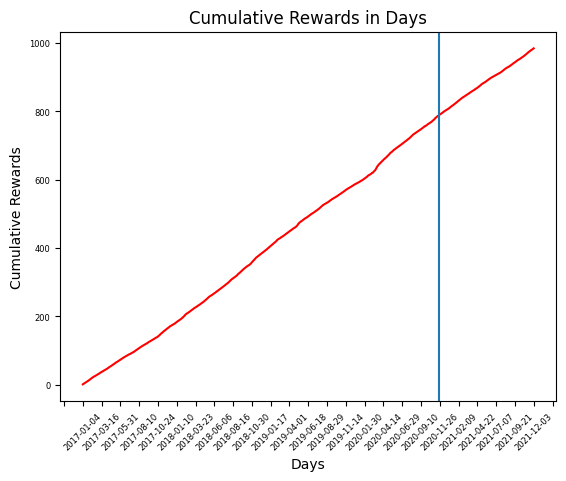

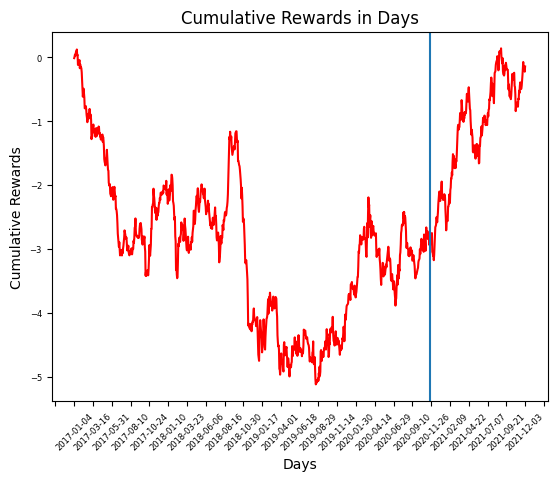

In [8]:
with open("./data/data_scale.pkl", 'rb') as f:
    df = pickle.load(f)


upper_df = df.sort_values(['date','tic']).reset_index(drop=True)
upper_df.index = upper_df.date.factorize()[0]
random_df = copy.deepcopy(upper_df)

upper_df.insert(loc = len(upper_df.columns), column = 'rank', value = upper_df['target'])

x = random_df['target'].tolist()
random.shuffle(x)
random_df.insert(loc = len(random_df.columns), column = 'rank', value = x)
date_memory = []
upper_portfolio_return_memory = []
random_portfolio_return_memory = []

for day in upper_df.index.unique():
    upper_portfolio_return = calc_spread_return_per_day(upper_df.loc[day])
    upper_portfolio_return_memory.append(upper_portfolio_return)
    random_portfolio_return = calc_spread_return_per_day(random_df.loc[day])
    random_portfolio_return_memory.append(random_portfolio_return)
    date_memory.append(upper_df.loc[day].date.unique()[0])

plot_cum_rewards(date_memory, upper_portfolio_return_memory)
plot_cum_rewards(date_memory, random_portfolio_return_memory)


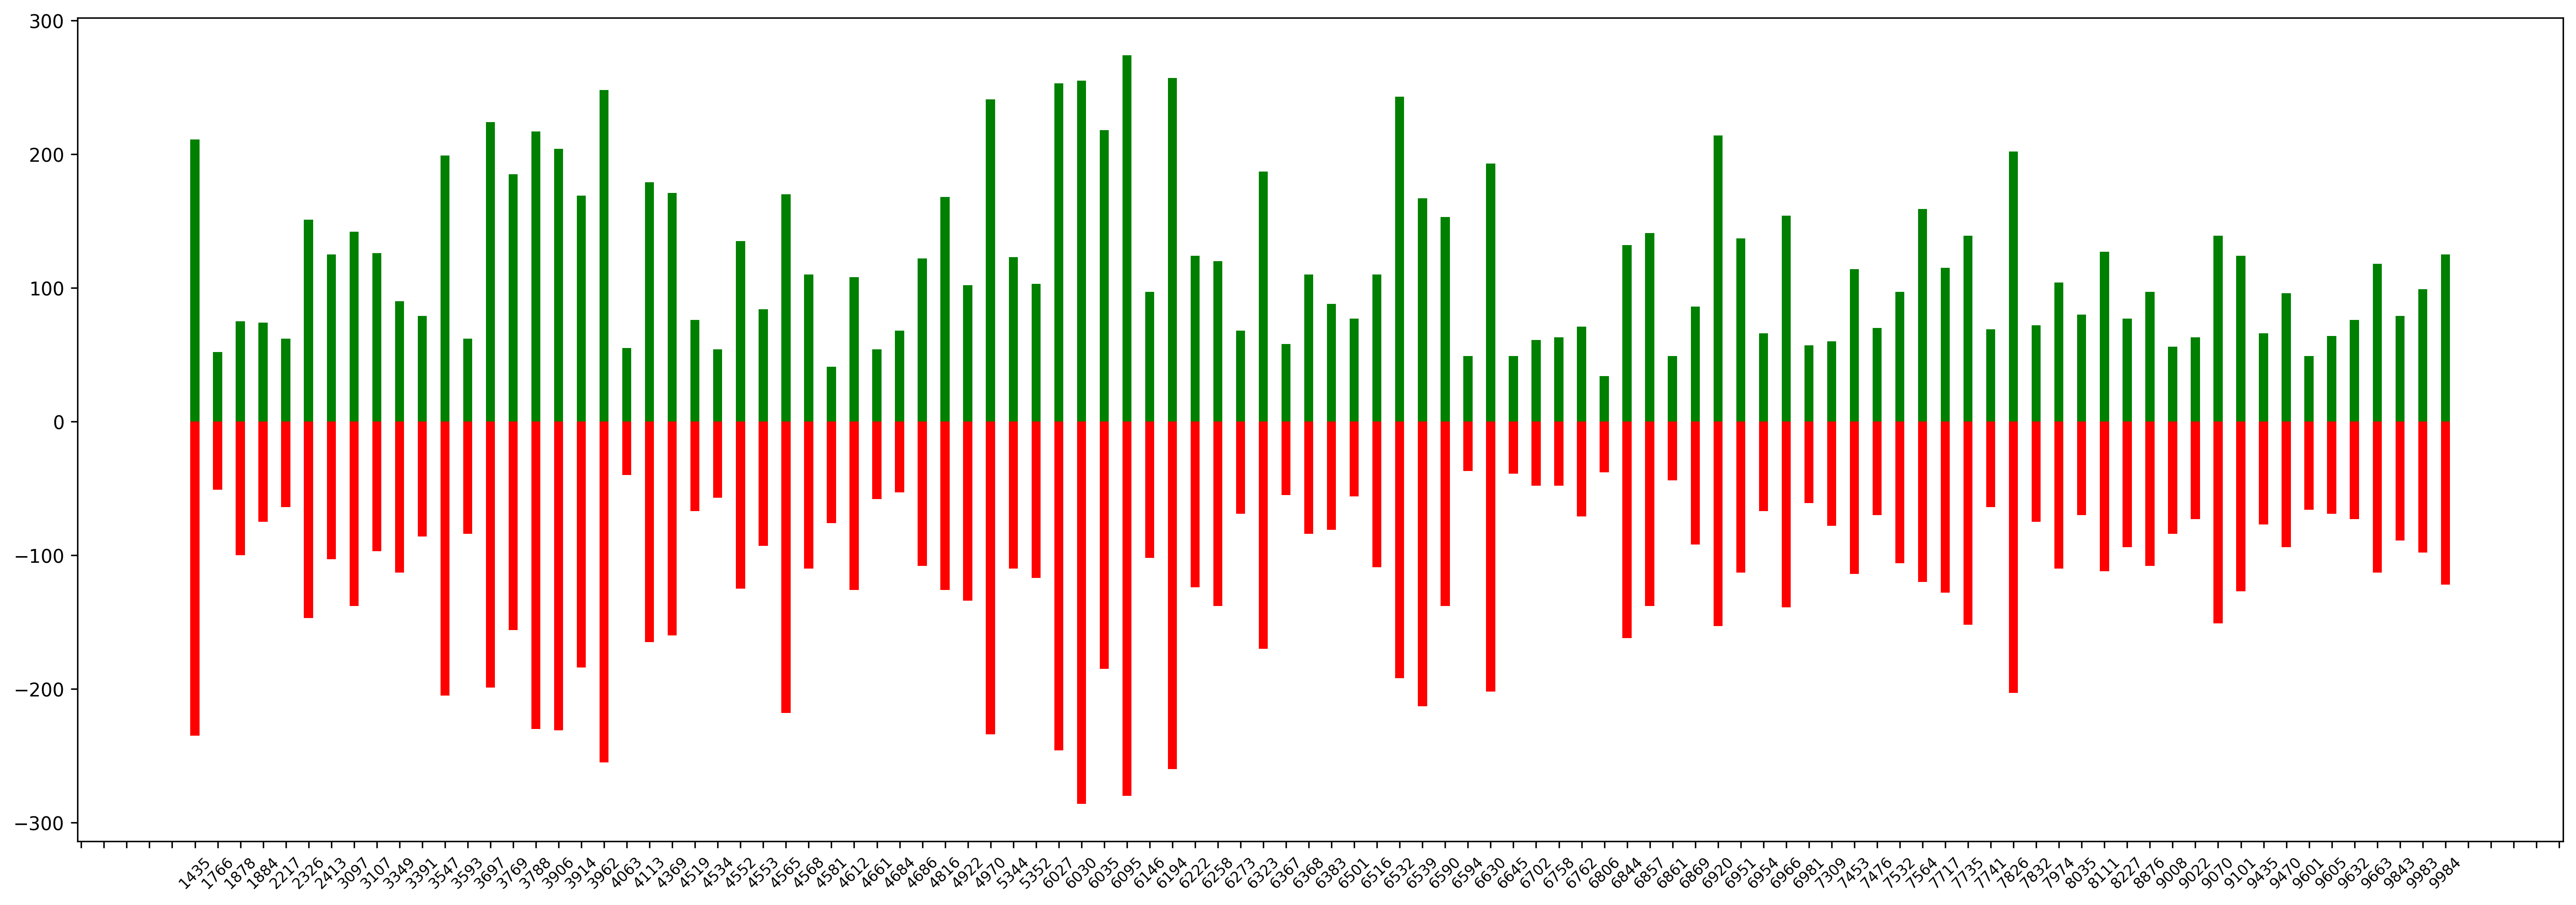

In [15]:
with open("./data/data_scale.pkl", 'rb') as f:
    df = pickle.load(f)
    
df = df.sort_values(['date','tic']).reset_index(drop=True)
df.index = df.date.factorize()[0]

top = defaultdict(int)
last = defaultdict(int)
for day in df.index.unique():
    tmp = df.loc[day]
    tmp = tmp.sort_values(by='target', ascending=False)['tic'].iloc[:10]
    tmp = tmp.to_list()
    for i in tmp:
        top[i] += 1
    tmp = df.loc[day]
    tmp = tmp.sort_values(by='target', ascending=True)['tic'].iloc[:10]
    tmp = tmp.to_list()
    for i in tmp:
        last[i] -= 1

plt.figure(dpi=300,figsize=(24,8))
tics = df.tic.unique()
for i,tic in enumerate(tics):
    # print(tic, top[tic], last[tic])
    plt.bar(i, top[tic], color = 'g', width=0.4)
    plt.bar(i, last[tic], color = 'r', width=0.4)
    
plt.xticks(range(len(tics)), tics, rotation=45, fontsize = 8)
ax=plt.gca()
x_major_locator=MultipleLocator(1)
ax.xaxis.set_major_locator(x_major_locator)
plt.show()
    
    
    

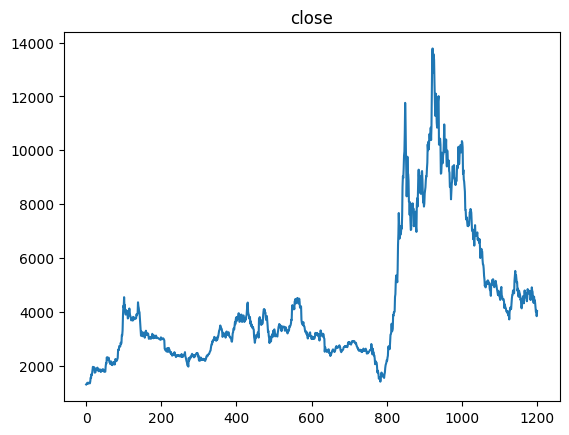

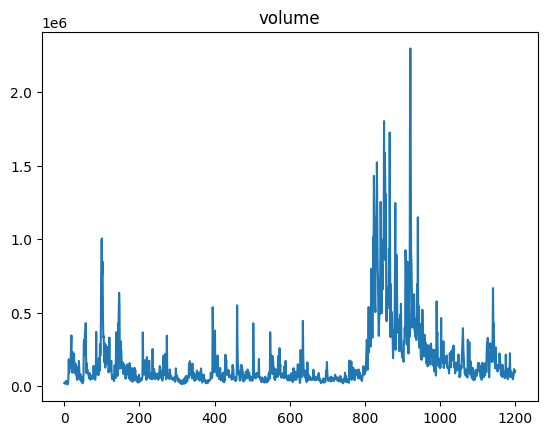

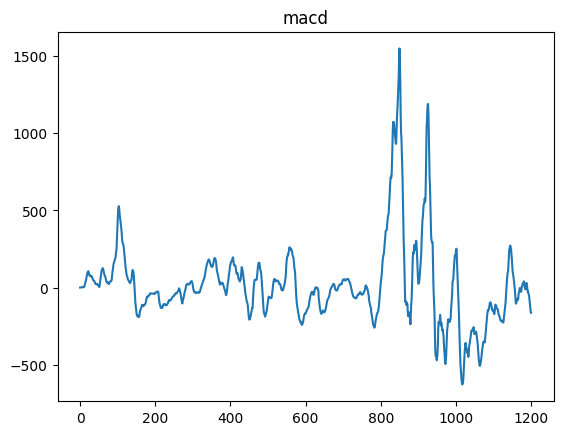

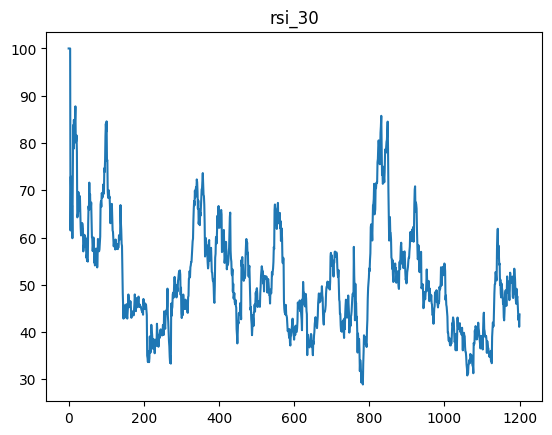

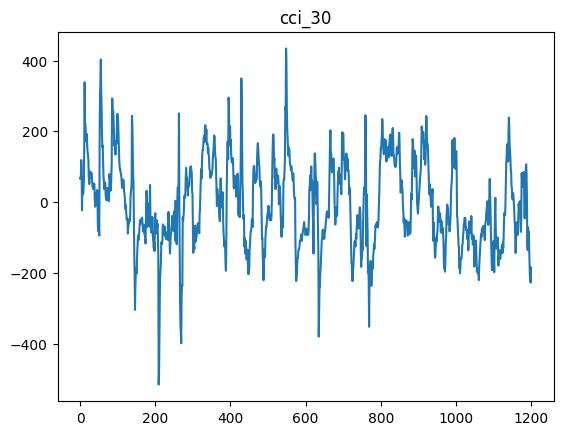

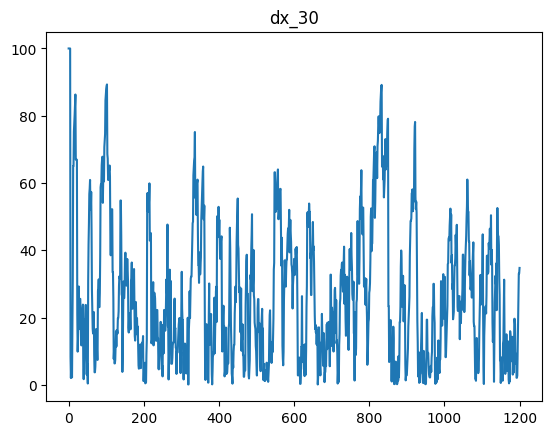

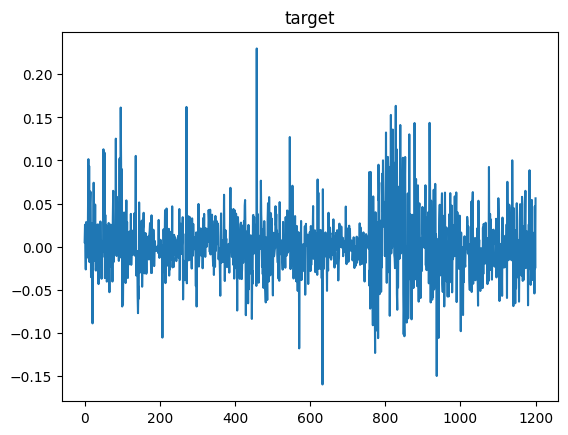

In [6]:
with open("./data/data_add_tech.pkl", 'rb') as f:
    df = pickle.load(f)
    
df = df.sort_values(['tic','date']).reset_index(drop=True)
df.index = df.date.factorize()[0]
features = ['close', 'volume', 'macd', 'rsi_30', 'cci_30', 'dx_30', 'target']
tic_name = 3914

for feature in features:
    data = np.array(df.loc[df.tic == tic_name][feature])
    plt.title(feature)
    plt.plot(range(len(data)), data)
    plt.show()
